# Active Learning Algorithms #

This notebook contains my implementation of two simple Active Learning Algorithms. I have also left the code `.py` file in the `code` folder, hoping that it it might be easier to imporve it with `git`. I expect that at some point this notebook might be deprecated, and will be be used mostly as a tutorial.  

The algorithms were developed using python programming language and a few python packages, as described in the README file.  

Active Learning is an interesting branch of Machine Learning. For some applications, health data for example, getting enough training samples with labels is a costly task. If, for example, a specialized physician has to be the one to label an MRI image as diseased or not, their time is not only expensive, but very precious. So there is an area of research that tries to indentify from an unlabeled pool of data which would be more important to be labeled and take that physician's time. Active learning algorithms are used to identify the unlabeled observations that need to be labeled and added to the training set to increase the accuracy of a machine learning model. Active Learning is a sampling problem, and here we will compare two different active learning strategies and see which one performs best for the data set at hand.  

We will try a Random active learning algorithm that samples randomly from the unlabeled data set at each iteration step and an Entropy-based algorithm that chooses the samples that had the highest uncertainty at each step. Given a small size training set (in this case 50 observations), it is important, if possible, to increase this number from a pool of unlabeled data in an intelligent way. We want to see which strategy would be better: getting random samples from the unlabeled data to be labeled or choosing specifically the most problematic ones. We are using entropy as a measure of uncertainty to choose the most problematic samples. We plot the accuracy versus iteration number for each algorithm and see which one helps increase the accuracy score faster. This will tell us which algorithm is better since the one that increases accuracy faster will need a smaller number of samples to be labeled.  

### The Data sets ###

Two facial expression recognition datasets containing six classes were used: MindReading and MMI. The Mind Reading data set tries to identify which specific image was already seen by an observer from a number of novel images shown based on fMRI activity (https://crcns.org/news/fmri-mind-reading-data-set-available). The MMI data set comes from a larger database of facial expresions where the ideia is to learn the feelings behind the expressions (https://mmifacedb.eu/). Both data sets have six classes to be predicted. 

Classification is a form of prediction where the goal is to predict the class labels, whether if it is binary or multiclass. The Scikit-Learn Logistic Regression model with a `liblinear` solver and max iterations set to 300 was used to fit the training data at each step and make predictions on the test data to calculate accuracy.  

***

### Libraries needed ###

This tutorial makes use of varying python libraries at each step. All libraries used are imported in this first step for clarity purposes and to show what requirements are needed at the beginning. Let's import the python libraries we will need:

In [1]:
#libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.io import loadmat
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

#### Function to import the Matlab files ####

The function below gets the files within the folder that was determined in the `path` variable and makes global variables with the data extracted from them. For this function the library `scipy.io` was used, more specifically the funciton `loadmat`. The `pandas` library is also needed, since the data is stored in a dataframe format. The library `os` is also required, with the specific functions needed described above. 

In [2]:
def importMatLab(path):
    """
    Function for importing several files in a folder with .mat format (Matlab).
    Saves each file data as a global variable and returns the names of these variables.
    The data is saved as a dataframe.
    
    Parameters
    ----------
    path : string
        the path to the folder where the .mat files are (only them should be in the file).
    Returns
    -------
    names (list of names of the variables that were created),

    """
    
    Mindlist = [f for f in listdir(path) if isfile(join(path, f))]
    n=len(Mindlist)    
    Mindfiles = Mindlist.copy() 
    for i in range(n):
        Mindfiles[i] = loadmat(join(path, Mindlist[i]))
    MindMatrixlist = Mindlist.copy()
    for i in range(n):
        MindMatrixlist[i] = [x for x in Mindfiles[i].popitem()]
    names1 = Mindlist.copy()
    names = [nm[ : -4] for nm in names1]
    for i in range(n):
        globals()[str(names[i])] = pd.DataFrame(MindMatrixlist[i][1])
    return(names)

#### Functions for the Active Learning Algorithms ####

For these functions a few packages are needed: `pandas`, `numpy`, `scikit-learn` as described above.  

In [14]:
##################################################
#Random Active Learning function
def RandomActiveLearning(model,xtrain,xtest,ytrain,ytest,unl,N=50,k=10):
    """
    Active learning random sampling algorithm.
    Parameters
    ----------
    model : classifier
        A classification algorithm that can handle multiple classes. 
        Scikit-Learn algorithms that have 'fit', 'predict', will work well.
    xtrain : dataframe
        Training Matrix.
    xtest : dataframe
        Testing Matrix.
    ytrain : 1D array
        Training Labels.
    ytest : 1D array
        Testing Labels.
    unl : dataframe
        Matrix with unlabeled data and last column of Labels named 'label'.
    N : integer, optional
        Number of iterations. The default is 50.
    k : integer, optional
        Number of samples to get from unlabeled at each iteration. The default is 10.

    Returns
    -------
    MiscTrain (list of accuracy for train data at each iteration),
    MiscTest (list of accuracy for test data at each iteration),
    DataSize (List with train data size at each iteration),
    iterations (List with iteration number).

    """
    
    MiscTrain = []
    MiscTest = []
    DataSize = []
    iterations = []
    
    for i in range(N):
        model.fit(xtrain, ytrain)
        predtrain = model.predict(xtrain)
        acctrain = accuracy_score(ytrain, predtrain)
        predtest = model.predict(xtest)
        acctest = accuracy_score(ytest, predtest)
        MiscTrain.append(acctrain)
        MiscTest.append(acctest)  
        
        sample = unl.sample(n=k, replace = False)      
        chosen_idx = sample.index
        x = sample.loc[:, sample.columns != 'label']
        xtrain = pd.concat([xtrain, x], ignore_index = True)
        
        ytrain = np.append(ytrain, sample['label'])
        
        unl.drop(index=chosen_idx, inplace=True)  
        unl.reset_index(drop=True)
        
        DataSize.append(xtrain.shape[0])
        iterations.append(i+1)
        print("Random", "iteration", i+1)
        
    return(MiscTrain,MiscTest,DataSize,iterations)
##################################################


##################################################
#the function for entropy-based active learning
def EntropyActiveLearning(model,xtrain,xtest,ytrain,ytest,unl,N=50,k=10):
    """
    Active learning entropy-based algorithm.
    Parameters
    ----------
    model : classifier
        A classification algorithm that can handle multiple classes. 
        Scikit-Learn algorithms that have 'fit', 'predict' and 'predict_proba', will work well.
    xtrain : dataframe
        Training Matrix.
    xtest : dataframe
        Testing Matrix.
    ytrain : 1D array
        Training Labels.
    ytest : 1D array
        Testing Labels.
    unl : dataframe
        Matrix with unlabeled data and last column of Labels named 'label'.
    N : integer, optional
        Number of iterations. The default is 50.
    k : integer, optional
        Number of samples to get from unlabeled at each iteration. The default is 10.

    Returns
    -------
    MiscTrain (list of accuracy for train data at each iteration),
    MiscTest (list of accuracy for test data at each iteration),
    DataSize (List with train data size at each iteration),
    iterations (List with iteration number).

    """
    
    MiscTrain = []
    MiscTest = []
    DataSize = []
    iterations = []
    
    for i in range(N):
        model.fit(xtrain, ytrain)
        predtrain = model.predict(xtrain)
        acctrain = accuracy_score(ytrain, predtrain)
        predtest = model.predict(xtest)
        acctest = accuracy_score(ytest, predtest)
        MiscTrain.append(acctrain)
        MiscTest.append(acctest)  
        
        prob = model.predict_proba(unl.loc[:,0:99])
        unl['entropy'] = (-prob*np.log2(prob)).sum(axis=1)
        
        # sort the DataFrame (entropy bigger is more uncertain, so sort descending)
        unl = unl.sort_values('entropy', ascending=False, ignore_index=True)
        # get the top ten ones
        sample = unl.iloc[0:k,:]      
        chosen_idx = sample.index
        x = sample.loc[:, 0:99]
        
        xtrain = pd.concat([xtrain, x], ignore_index = True)
        
        ytrain = np.append(ytrain, sample['label'])
        
        unl.drop(index=chosen_idx, inplace=True)  
        unl.reset_index(drop=True)
        
        DataSize.append(xtrain.shape[0])
        iterations.append(i+1)
        print("Entropy", "iteration", i+1)
        
    return(MiscTrain,MiscTest,DataSize,iterations)

#### Model used for classification ####

In [4]:
#Model used for the active learning functions
model = LogisticRegression(solver='liblinear', max_iter=300,random_state=0)


### MindReading data ###

In [16]:
#saving the path to where the files for the MindReading data are
pathMind = "/Users/schama/Desktop/Data/MindReading/"
#calling the import function
names = importMatLab(pathMind)

#saving variables to new names and flattening the labels
ytest_1 = np.ravel(testingLabels_MindReading1.copy())
ytest_2 = np.ravel(testingLabels_MindReading2.copy())
ytest_3 = np.ravel(testingLabels_MindReading3.copy())
xtest_1 = testingMatrix_MindReading1.copy()
xtest_2 = testingMatrix_MindReading2.copy()
xtest_3 = testingMatrix_MindReading3.copy()
ytrain_1 = np.ravel(trainingLabels_MindReading_1.copy())
ytrain_2 = np.ravel(trainingLabels_MindReading_2.copy())
ytrain_3 = np.ravel(trainingLabels_MindReading_3.copy())
xtrain_1 = trainingMatrix_MindReading1.copy()
xtrain_2 = trainingMatrix_MindReading2.copy()
xtrain_3 = trainingMatrix_MindReading3.copy()
yunl_1 = unlabeledLabels_MindReading_1.copy()
yunl_2 = unlabeledLabels_MindReading_2.copy()
yunl_3 = unlabeledLabels_MindReading_3.copy()
xunl_1 = unlabeledMatrix_MindReading1.copy()
xunl_2 = unlabeledMatrix_MindReading2.copy()
xunl_3 = unlabeledMatrix_MindReading3.copy()

#joining the matrix and labels for unlabeled data
xyunl_1 = xunl_1.assign(label=yunl_1)
xyunl_2 = xunl_2.assign(label=yunl_2)
xyunl_3 = xunl_3.assign(label=yunl_3)

In [17]:
#running the Random Active Learning function
MiscTrain,MiscTest,DataSize,iterations = RandomActiveLearning(model,xtrain_1, xtest_1, ytrain_1, ytest_1, xyunl_1)
MiscTrain2,MiscTest2,DataSize2,iterations2 = RandomActiveLearning(model,xtrain_2, xtest_2, ytrain_2, ytest_2, xyunl_2)
MiscTrain3,MiscTest3,DataSize3,iterations3 = RandomActiveLearning(model,xtrain_3, xtest_3, ytrain_3, ytest_3, xyunl_3)
#running the Entropy Active Learning Function
MiscTrainE,MiscTestE,DataSizeE,iterationsE = EntropyActiveLearning(model,xtrain_1, xtest_1, ytrain_1, ytest_1, xyunl_1)
MiscTrain2E,MiscTest2E,DataSize2,iterations2E = EntropyActiveLearning(model,xtrain_2, xtest_2, ytrain_2, ytest_2, xyunl_2)
MiscTrain3E,MiscTest3E,DataSize3E,iterations3E = EntropyActiveLearning(model,xtrain_3, xtest_3, ytrain_3, ytest_3, xyunl_3)


Random iteration 1
Random iteration 2
Random iteration 3
Random iteration 4
Random iteration 5
Random iteration 6
Random iteration 7
Random iteration 8
Random iteration 9
Random iteration 10
Random iteration 11
Random iteration 12
Random iteration 13
Random iteration 14
Random iteration 15
Random iteration 16
Random iteration 17
Random iteration 18
Random iteration 19
Random iteration 20
Random iteration 21
Random iteration 22
Random iteration 23
Random iteration 24
Random iteration 25
Random iteration 26
Random iteration 27
Random iteration 28
Random iteration 29
Random iteration 30
Random iteration 31
Random iteration 32
Random iteration 33
Random iteration 34
Random iteration 35
Random iteration 36
Random iteration 37
Random iteration 38
Random iteration 39
Random iteration 40
Random iteration 41
Random iteration 42
Random iteration 43
Random iteration 44
Random iteration 45
Random iteration 46
Random iteration 47
Random iteration 48
Random iteration 49
Random iteration 50
Random it

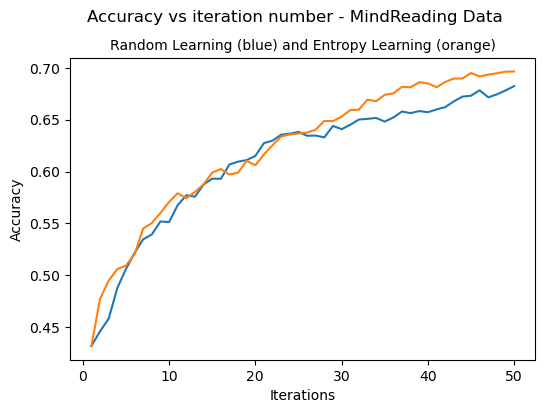

In [18]:
#saving the data to plot
#MindData Table and data frame - RANDOM ACTIVE LEARNING
table1 = {'Dataset1':MiscTest, 'Dataset2': MiscTest2, 'Dataset3': MiscTest3}
df = pd.DataFrame(table1)
#calculating the average
df['average'] = df.mean(axis=1)

#MindData Table and data frame - ENTROPY ACTIVE LEARNING
table2 = {'Dataset1':MiscTestE, 'Dataset2': MiscTest2E, 'Dataset3': MiscTest3E}
df2 = pd.DataFrame(table2)
#calculating the average
df2['averageENTROPY'] = df2.mean(axis=1)

#Final Plot both active learning algorithm with MindReading data
fig, ax = plt.subplots()  # a figure with one plot
ax.autoscale()
fig.set_dpi(100)
plt.suptitle('Accuracy vs iteration number - MindReading Data',fontsize=12, y=1)
plt.title('Random Learning (blue) and Entropy Learning (orange)', fontsize=10)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(iterations,df['average'])
plt.plot(iterations,df2['averageENTROPY'])
plt.show()

### MMI data ###

In [19]:
#MMI dataset
#path to the folder where the data is
pathMMI = "/Users/schama/Desktop/Data/MMI/"
#calling the function to import data
namesMMI = importMatLab(pathMMI)

#saving variables to new names and flattening the labels
ytest_1 = np.ravel(testingLabels_1.copy())
ytest_2 = np.ravel(testingLabels_2.copy())
ytest_3 = np.ravel(testingLabels_3.copy())
xtest_1 = testingMatrix_1.copy()
xtest_2 = testingMatrix_2.copy()
xtest_3 = testingMatrix_3.copy()
ytrain_1 = np.ravel(trainingLabels_1.copy())
ytrain_2 = np.ravel(trainingLabels_2.copy())
ytrain_3 = np.ravel(trainingLabels_3.copy())
xtrain_1 = trainingMatrix_1.copy()
xtrain_2 = trainingMatrix_2.copy()
xtrain_3 = trainingMatrix_3.copy()
yunl_1 = unlabeledLabels_1.copy()
yunl_2 = unlabeledLabels_2.copy()
yunl_3 = unlabeledLabels_3.copy()
xunl_1 = unlabeledMatrix_1.copy()
xunl_2 = unlabeledMatrix_2.copy()
xunl_3 = unlabeledMatrix_3.copy()
#joining the matrix and labels for unlabeled data
xyunl_1 = xunl_1.assign(label=yunl_1)
xyunl_2 = xunl_2.assign(label=yunl_2)
xyunl_3 = xunl_3.assign(label=yunl_3)

In [20]:
#random active learning
MiscTrain4,MiscTest4,DataSize4,iterations4 = RandomActiveLearning(model,xtrain_1, xtest_1, ytrain_1, ytest_1, xyunl_1)
MiscTrain5,MiscTest5,DataSize5,iterations5 = RandomActiveLearning(model,xtrain_2, xtest_2, ytrain_2, ytest_2, xyunl_2)
MiscTrain6,MiscTest6,DataSize6,iterations6 = RandomActiveLearning(model,xtrain_3, xtest_3, ytrain_3, ytest_3, xyunl_3)

#entropy active learning
MiscTrain4E,MiscTest4E,DataSize4E,iterations4E = EntropyActiveLearning(model,xtrain_1, xtest_1, ytrain_1, ytest_1, xyunl_1)
MiscTrain5E,MiscTest5E,DataSize5E,iterations5E = EntropyActiveLearning(model,xtrain_2, xtest_2, ytrain_2, ytest_2, xyunl_2)
MiscTrain6E,MiscTest6E,DataSize6E,iterations6E = EntropyActiveLearning(model,xtrain_3, xtest_3, ytrain_3, ytest_3, xyunl_3)


Random iteration 1
Random iteration 2
Random iteration 3
Random iteration 4
Random iteration 5
Random iteration 6
Random iteration 7
Random iteration 8
Random iteration 9
Random iteration 10
Random iteration 11
Random iteration 12
Random iteration 13
Random iteration 14
Random iteration 15
Random iteration 16
Random iteration 17
Random iteration 18
Random iteration 19
Random iteration 20
Random iteration 21
Random iteration 22
Random iteration 23
Random iteration 24
Random iteration 25
Random iteration 26
Random iteration 27
Random iteration 28
Random iteration 29
Random iteration 30
Random iteration 31
Random iteration 32
Random iteration 33
Random iteration 34
Random iteration 35
Random iteration 36
Random iteration 37
Random iteration 38
Random iteration 39
Random iteration 40
Random iteration 41
Random iteration 42
Random iteration 43
Random iteration 44
Random iteration 45
Random iteration 46
Random iteration 47
Random iteration 48
Random iteration 49
Random iteration 50
Random it

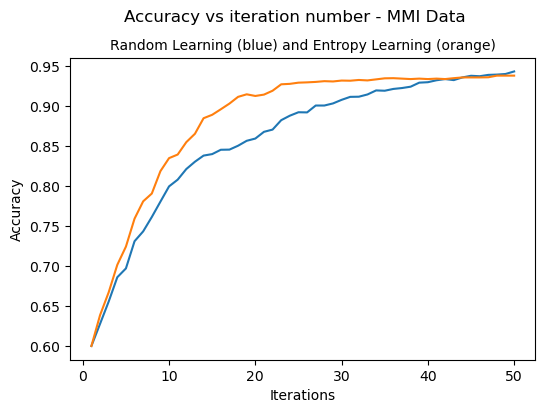

In [21]:
#Saving the data to plot
#MMI Table and data frame - Random Learning
table1 = {'MMI1':MiscTest4, 'MMI2': MiscTest5, 'MMI3': MiscTest6}
df = pd.DataFrame(table1)
#Calculating average
df['average'] = df.mean(axis=1)

#MMI Table and data frame - Entroby-based Learning
table2 = {'MMI1':MiscTest4E, 'MMI2': MiscTest5E, 'MMI3': MiscTest6E}
df2 = pd.DataFrame(table2)
#Calculating average
df2['averageENTROPY'] = df2.mean(axis=1)

#saving the results to a file
fig, ax = plt.subplots()  # a figure with one plot
ax.autoscale()
fig.set_dpi(100)
plt.suptitle('Accuracy vs iteration number - MMI Data',fontsize=12, y=1)
plt.title('Random Learning (blue) and Entropy Learning (orange)', fontsize=10)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(iterations,df['average'])
plt.plot(iterations,df2['averageENTROPY'])
plt.show()

The default number of iterations ($N$) was 50 and at each step 10 samples were taken from the unlabeled set ($k$).
 In many fields getting labeled data is costly and finding a way to identify the unlabeled data that should be labeled is an important task.  

The experiments were performed three times with each data set and the average results are reported. We can see from both figures above that the Entropy-base active learning algorithm (orange line) seems to perform best. In both plots, its accuracy score increases faster than the one for the Random Sampling algorithm (blue line).  